load data
plot data

In [1]:
import numpy as np
import pickle
import pandas as pd
import time
from umap import UMAP

In [2]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [3]:
from tfumap.paths import FIGURE_DIR, save_fig

In [4]:
save_loc = DATA_DIR / 'knn_classifier' 

In [5]:
datasets = [
    'cassins_dtw',
    'cifar10',
    'fmnist',
    'macosko2015',
    'mnist'
]

In [6]:
projection_speeds = pd.concat([pd.read_pickle(save_loc / (dataset + '.pickle')) for dataset in datasets])
projection_speeds[:3]

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cassins_dtw,0.991,0.995
1,network,64,cassins_dtw,0.988,0.991
2,autoencoder,2,cassins_dtw,0.989,0.993


In [7]:
# load parametric tsne, vae, ae
for dataset in datasets:
    for n_components in ['2', '64']:
        save_loc =  DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
        try:
            metric_df = pd.read_pickle(save_loc)
            projection_speeds = pd.concat([projection_speeds, metric_df])
        except FileNotFoundError:
            print(save_loc)
            
        vae_save_loc = (
            DATA_DIR
            / "knn_classifier"
            / 'vae'
            / "train"
            / str(n_components)
            / (dataset + ".pickle")
        )
        try:
            metric_df = pd.read_pickle(vae_save_loc)
            # display(metric_df)
            projection_speeds = pd.concat([projection_speeds, metric_df])
        except FileNotFoundError:
            print(vae_save_loc)
            
        ae_save_loc = (
            DATA_DIR
            / "knn_classifier"
            / 'ae_only'
            / "train"
            / str(n_components)
            / (dataset + ".pickle")
        )
        try:
            metric_df = pd.read_pickle(ae_save_loc)
            # display(metric_df)
            projection_speeds = pd.concat([projection_speeds, metric_df])
        except FileNotFoundError:
            print(ae_save_loc)

In [8]:
projection_speeds

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cassins_dtw,0.9910,0.9950
1,network,64,cassins_dtw,0.9880,0.9910
2,autoencoder,2,cassins_dtw,0.9890,0.9930
3,autoencoder,64,cassins_dtw,0.9940,0.9970
4,umap-learn,2,cassins_dtw,0.9860,0.9890
...,...,...,...,...,...
0,vae,2,mnist,0.7241,0.7649
0,ae_only,2,mnist,0.7647,0.7926
0,parametric-tsne,64,mnist,0.9697,0.9734
0,vae,64,mnist,0.9785,0.9791


In [9]:
projection_speeds.method_.unique()

array(['network', 'autoencoder', 'umap-learn', 'PCA', 'TSNE',
       'parametric-tsne', 'vae', 'ae_only'], dtype=object)

In [10]:
projection_speeds.loc[projection_speeds.dataset == 'cassins', 'dataset'] = 'cassins_dtw'
#projection_speeds.loc[projection_speeds.dataset == 'makosco2015', 'dataset'] = 'macoco2015'

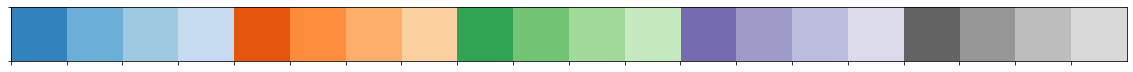

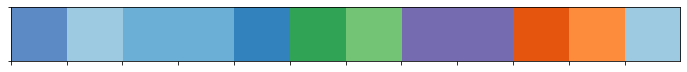

In [15]:
pal20c = sns.color_palette('tab20c', 20)
sns.palplot(pal20c)
hue_dict = {
    "umap-learn": list(np.array(pal20c[3])**4),
    "direct": pal20c[2],
    "AE": pal20c[1],
    "autoencoder": pal20c[1],
    "network": pal20c[0],
    'vae':  pal20c[8], 
    'ae_only':  pal20c[9],
    "pca":  pal20c[12],
    "PCA":  pal20c[12],
    "TSNE": pal20c[4], 
    "parametric-tsne":pal20c[5],
    "network-cpu": pal20c[2],

}
sns.palplot([hue_dict[i] for i in hue_dict.keys()])

### K=1

In [27]:
hue_list = ["TSNE", "parametric-tsne", "umap-learn",  "network", "autoencoder", 'vae', 'ae_only', "PCA"]

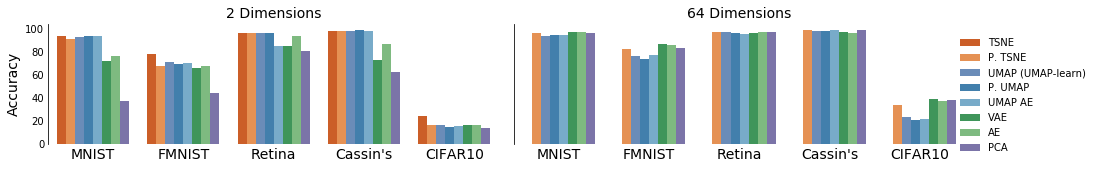

In [43]:
#sns.set(font_scale=1.0)
import matplotlib as mpl
axes = {'labelsize': 14,
        'titlesize': 14,}
mpl.rc('axes', **axes)
mpl.rcParams['xtick.labelsize'] = 14

median_df = (
    projection_speeds[["method_", "dimensions", "dataset", "1NN_acc"]]
    .groupby(["method_", "dimensions", "dataset"])
    .median()
)
median_df = median_df.T.melt()
median_df["value"]*=100
median_df["error"] = 100 - median_df["value"]
fg = sns.catplot(
    x="dataset",
    y="value",
    hue="method_",
    hue_order=hue_list,
    order=["mnist", "fmnist", "macosko2015", "cassins_dtw", "cifar10"],
    col="dimensions",
    height=2.75,
    aspect=2.5,
    data=median_df,
    kind="bar",
    palette=[hue_dict[i] for i in hue_list],
    # legend=False
)
(
    fg.despine(bottom=True)
    .set_xticklabels(["MNIST", "FMNIST", "Retina", "Cassin's", "CIFAR10"])
    .set_axis_labels("", "Accuracy")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u"both", which=u"both", length=0)
fg._legend._legend_title_box._text.set_text("")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'umap-learn'))[0][0]].set_text('UMAP (UMAP-learn)')

fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "network"))[0][0]
].set_text("P. UMAP")
fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "autoencoder"))[0][0]
].set_text("UMAP AE")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'parametric-tsne'))[0][0]].set_text('P. TSNE')
# fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'pca'))[0][0]].set_text('PCA')
# fg._legend.texts[3].set_text("PCA")
# ax.set_ylim([1e-10,1e-3])
# ax.set_yscale('log')
# fg._legend.texts[2].set_text("Param. UMAP")

ax.set_title("2 Dimensions")
ax = fg.axes[0][1]
ax.tick_params(axis=u"both", which=u"both", length=0)

ax.set_title("64 Dimensions")
# ax.set_yscale('log')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'ae_only'))[0][0]].set_text('AE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'vae'))[0][0]].set_text('VAE')

save_fig(FIGURE_DIR/'1nn_acc_results', save_pdf=True, dpi=300, pad_inches=0.1)

Text(0.5, 1, '64 Dimensions')

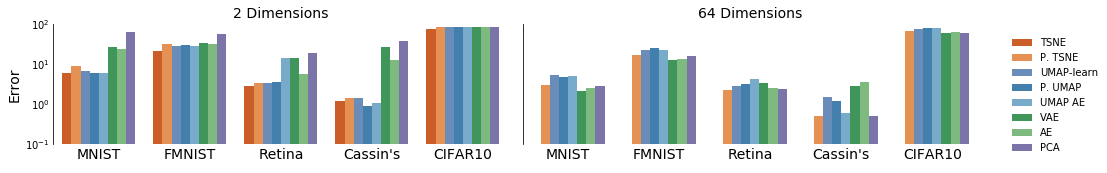

In [44]:
fg = sns.catplot(
    x="dataset",
    y="error",
    hue="method_",
    hue_order=["TSNE","parametric-tsne",  "umap-learn", "network", "autoencoder", 'vae', 'ae_only', "PCA"],
    order = ['mnist', 'fmnist', 'macosko2015', 'cassins_dtw', 'cifar10'],
    col="dimensions",
    height=2.75, 
    aspect=2.5,
    data=median_df,
    kind="bar",
    palette=[hue_dict[i] for i in hue_list],
    #legend=False
)
(fg.despine(bottom=True)
 .set_xticklabels(['MNIST', 'FMNIST', 'Retina', 'Cassin\'s', 'CIFAR10'])
 .set_axis_labels("", "Error")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u'both', which=u'both',length=0)
fg._legend._legend_title_box._text.set_text("")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'parametric-tsne'))[0][0]].set_text('P. TSNE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'umap-learn'))[0][0]].set_text('UMAP (UMAP-learn)')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'network'))[0][0]].set_text('P. UMAP')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'autoencoder'))[0][0]].set_text('UMAP AE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'ae_only'))[0][0]].set_text('AE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'vae'))[0][0]].set_text('VAE')
ax.set_ylim([1e-1,100])
ax.set_yscale('log')
#fg._legend.texts[2].set_text("Param. UMAP")

ax.set_title('2 Dimensions')
ax = fg.axes[0][1]
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_title('64 Dimensions')
#ax.set_yscale('log')

#save_fig(FIGURE_DIR/'knn_classifier_results', save_pdf=True, dpi=300, pad_inches=0.1)

### K = 5

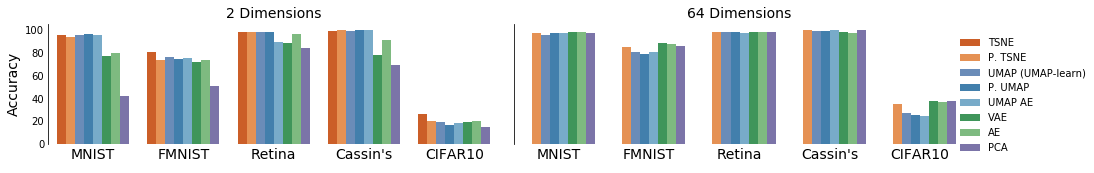

In [40]:
#sns.set(font_scale=1.0)
import matplotlib as mpl
axes = {'labelsize': 14,
        'titlesize': 14,}
mpl.rc('axes', **axes)
mpl.rcParams['xtick.labelsize'] = 14

median_df = (
    projection_speeds[["method_", "dimensions", "dataset", "5NN_acc"]]
    .groupby(["method_", "dimensions", "dataset"])
    .median()
)
median_df = median_df.T.melt()
median_df["value"]*=100
median_df["error"] = 100 - median_df["value"]
fg = sns.catplot(
    x="dataset",
    y="value",
    hue="method_",
    hue_order=["TSNE", "parametric-tsne", "umap-learn", "network", "autoencoder", 'vae', 'ae_only', "PCA"],
    order=["mnist", "fmnist", "macosko2015", "cassins_dtw", "cifar10"],
    col="dimensions",
    height=2.75,
    aspect=2.5,
    data=median_df,
    kind="bar",
    palette=[hue_dict[i] for i in hue_list],
    # legend=False
)
(
    fg.despine(bottom=True)
    .set_xticklabels(["MNIST", "FMNIST", "Retina", "Cassin's", "CIFAR10"])
    .set_axis_labels("", "Accuracy")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u"both", which=u"both", length=0)
fg._legend._legend_title_box._text.set_text("")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'umap-learn'))[0][0]].set_text('UMAP (UMAP-learn)')

fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "network"))[0][0]
].set_text("P. UMAP")
fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "autoencoder"))[0][0]
].set_text("UMAP AE")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'ae_only'))[0][0]].set_text('AE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'vae'))[0][0]].set_text('VAE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'parametric-tsne'))[0][0]].set_text('P. TSNE')
# fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'pca'))[0][0]].set_text('PCA')
# fg._legend.texts[3].set_text("PCA")
# ax.set_ylim([1e-10,1e-3])
# ax.set_yscale('log')
# fg._legend.texts[2].set_text("Param. UMAP")

ax.set_title("2 Dimensions")
ax = fg.axes[0][1]
ax.tick_params(axis=u"both", which=u"both", length=0)

ax.set_title("64 Dimensions")
# ax.set_yscale('log')

save_fig(FIGURE_DIR/'5nn_acc_results', save_pdf=True, dpi=300, pad_inches=0.1)

Text(0.5, 1, '64 Dimensions')

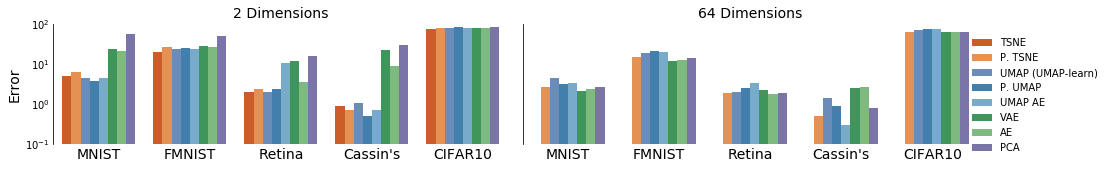

In [41]:
#sns.set(font_scale=1.0)
import matplotlib as mpl
axes = {'labelsize': 14,
        'titlesize': 14,}
mpl.rc('axes', **axes)
mpl.rcParams['xtick.labelsize'] = 14

fg = sns.catplot(
    x="dataset",
    y="error",
    hue="method_",
    hue_order=["TSNE", "parametric-tsne", "umap-learn", "network", "autoencoder", 'vae', 'ae_only', "PCA"],
    order = ['mnist', 'fmnist', 'macosko2015', 'cassins_dtw', 'cifar10'],
    col="dimensions",
    height=2.75, 
    aspect=2.5,
    data=median_df,
    kind="bar",
    palette=[hue_dict[i] for i in hue_list],
    #legend=False
)
(fg.despine(bottom=True)
 .set_xticklabels(['MNIST', 'FMNIST', 'Retina', 'Cassin\'s', 'CIFAR10'])
 .set_axis_labels("", "Error")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u'both', which=u'both',length=0)
fg._legend._legend_title_box._text.set_text("")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'parametric-tsne'))[0][0]].set_text('P. TSNE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'umap-learn'))[0][0]].set_text('UMAP (UMAP-learn)')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'network'))[0][0]].set_text('P. UMAP')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'autoencoder'))[0][0]].set_text('UMAP AE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'ae_only'))[0][0]].set_text('AE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'vae'))[0][0]].set_text('VAE')
ax.set_ylim([1e-1,100])
ax.set_yscale('log')
#fg._legend.texts[2].set_text("Param. UMAP")

ax.set_title('2 Dimensions')
ax = fg.axes[0][1]
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_title('64 Dimensions')
#ax.set_yscale('log')

#save_fig(FIGURE_DIR/'knn_classifier_results', save_pdf=True, dpi=300, pad_inches=0.1)

In [ ]:
# 2 AMD EPYC Rome 7252 8-Core 3.1 GHz  processors 

### Make latex table

In [ ]:
projection_speeds[:3]

In [ ]:
proj_speed_melt = pd.melt(
    projection_speeds,
    id_vars=["method_", "dimensions", "dataset"],
    value_vars=["1NN_acc", "5NN_acc"],
)
proj_speed_melt.rename(columns={'variable':'metric'}, inplace=True)
proj_speed_melt

In [ ]:
unique_datasets = list(projection_speeds.dataset.unique())
unique_dims = list(projection_speeds.dimensions.unique())
unique_metric = ['1NN_acc', '5NN_acc']
unique_method = list(projection_speeds.method_.unique())
unique_datasets, unique_dims, unique_metric, unique_method

In [ ]:
proj_speed_melt[:3]

In [ ]:
r0, r0n = unique_method, "method_" 
r1, r1n = unique_dims, "dimensions"
c0, c0n = unique_datasets, "dataset" 
c1, c1n = unique_metric, "metric"
row_idx = [
    np.concatenate([list(np.repeat(i, len(r1))) for i in r0]),
    np.concatenate([list(r1) for i in r0]),  
]
row_idx = pd.MultiIndex.from_tuples(list(zip(*row_idx)), names=[r0n, r1n])
col_idx = [
    np.concatenate([list(np.repeat(i, len(c1))) for i in c0]),
    np.concatenate([list(c1) for i in c0]),  

]
col_idx = pd.MultiIndex.from_tuples(list(zip(*col_idx)), names=[c0n, c1n])
results_df = pd.DataFrame(-1*np.ones((len(row_idx), len(col_idx))), index=row_idx, columns=col_idx)
for method_ in unique_method:
    for dataset in unique_datasets:
        for dim in unique_dims:
            for metric in unique_metric:
                val = proj_speed_melt[
                    (proj_speed_melt.dataset == dataset) &
                   (proj_speed_melt.method_ == method_) &
                   (proj_speed_melt.dimensions == dim) & 
                   (proj_speed_melt['metric'] == metric)
                  ]['value']
                if len(val) > 0:
                     results_df.loc[(method_,dim), (dataset, metric)] = round(list(val)[0],3)
results_df

In [ ]:
results_latex = results_df.to_latex(
    bold_rows=True, multirow=True, multicolumn=True, multicolumn_format="l"
)
replace_list = [
    ["\\begin{tabular}", "\\begin{table}\n\\begin{tabular}"],
    ["\\end{tabular}", "\\end{tabular}\n\\end{table}"],
    ["-1.000", "-"],
    ["-1.00", "-"],
    ["fmnist", "\\textbf{FMNIST}"],
    ["mnist", "\\textbf{MNIST}"],
    ["macosko2015", "\\textbf{Retina}"],
    ["cassins\_dtw", "\\textbf{Cassin's}"],
    ["cifar10", "\\textbf{CIFAR10}"],
    ["dataset", ""],
    ["metric", ""],
    ["dimensions", ""],
    ["method_", ""],
    ["1NN\_acc", "k=1"],
    ["5NN\_acc", "k=5"],
    
    ["\\end{tabular}",
     "\\end{tabular}\n\caption{KNN Clustering metrics for each dataset"]
]
for i, j in replace_list:
    results_latex = results_latex.replace(i, j)
print(results_latex)

In [ ]:
col_idx

In [ ]:
r0, r0n = unique_method, "method_" 
r1, r1n = unique_dims, "dimensions"
c0, c0n = unique_datasets, "dataset" 
c1, c1n = unique_metric, "metric"
row_idx = [list(r0)]
row_idx = pd.MultiIndex.from_tuples(list(zip(*row_idx)), names=[r0n])
col_idx = [
    np.concatenate([list(np.repeat(i, len(c1)*len(r1))) for i in c0]),
    np.concatenate([list(np.repeat(r1, len(c1))) for j in r1 for i in c0]),
    np.concatenate([list(c1) for j in r1  for i in c0]),  

]
col_idx = pd.MultiIndex.from_tuples(list(zip(*col_idx)), names=[c0n, r1n,c1n])
results_df = pd.DataFrame(-1*np.ones((len(row_idx), len(col_idx))), index=row_idx, columns=col_idx)
for method_ in unique_method:
    for dataset in unique_datasets:
        for dim in unique_dims:
            for metric in unique_metric:
                val = proj_speed_melt[
                    (proj_speed_melt.dataset == dataset) &
                   (proj_speed_melt.method_ == method_) &
                   (proj_speed_melt.dimensions == dim) & 
                   (proj_speed_melt['metric'] == metric)
                  ]['value']
                if len(val) > 0:
                     results_df.loc[method_, (dataset, dim ,metric)] = round(list(val)[0],3)
results_df


In [ ]:
results_latex = results_df.to_latex(
    bold_rows=True, multirow=True, multicolumn=True, multicolumn_format="l"
)
replace_list = [
    ["\\begin{tabular}", "\\begin{table}\n\\begin{tabular}"],
    ["\\end{tabular}", "\\end{tabular}\n\\end{table}"],
    ["-1.000", "-"],
    ["-1.00", "-"],
    ["fmnist", "\\textbf{FMNIST}"],
    ["mnist", "\\textbf{MNIST}"],
    ["macosko2015", "\\textbf{Retina}"],
    ["cassins\_dtw", "\\textbf{Cassin's}"],
    ["cifar10", "\\textbf{CIFAR10}"],
    ["dataset", ""],
    ["metric", ""],
    ["dimensions", ""],
    ["method_", ""],
    ["1NN\_acc", "k=1"],
    ["5NN\_acc", "k=5"],
    
    ["\\end{tabular}",
     "\\end{tabular}\n\caption{KNN Clustering metrics for each dataset"]
]
for i, j in replace_list:
    results_latex = results_latex.replace(i, j)
print(results_latex)